## 遥感数据+机器学习
1. 因为数据太大了，导致不能上传到GitHub上。
2. 同时为了给我的公众号引流，可以关注我的公众号：【world of statistics】，然后回复【气象数据】
3. 本代码按照这篇文章来的: https://urbanspatial.github.io/classifying_satellite_imagery_in_R/

## 安装要求
1. rasterio: `pip install rasterio`
2. ipympl: `pip install ipympl`
3. 别的包就非常常见了，只要是使用anaconda的都有

In [209]:
import geopandas as gpd
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt 
import rasterio
import seaborn as sns
from matplotlib import cm

In [7]:
%matplotlib widget

### 加载、处理栅格数据

In [141]:
dataset_list = [rasterio.open(f'数据集/data20220907/band/band{i}.tif') for i in range(1, 12) if i != 8]
dataset_list

[<open DatasetReader name='数据集/data20220907/band/band1.tif' mode='r'>,
 <open DatasetReader name='数据集/data20220907/band/band2.tif' mode='r'>,
 <open DatasetReader name='数据集/data20220907/band/band3.tif' mode='r'>,
 <open DatasetReader name='数据集/data20220907/band/band4.tif' mode='r'>,
 <open DatasetReader name='数据集/data20220907/band/band5.tif' mode='r'>,
 <open DatasetReader name='数据集/data20220907/band/band6.tif' mode='r'>,
 <open DatasetReader name='数据集/data20220907/band/band7.tif' mode='r'>,
 <open DatasetReader name='数据集/data20220907/band/band9.tif' mode='r'>,
 <open DatasetReader name='数据集/data20220907/band/band10.tif' mode='r'>,
 <open DatasetReader name='数据集/data20220907/band/band11.tif' mode='r'>]

In [142]:
dataset_list[0].transform

Affine(30.0, 0.0, 266712.4954125264,
       0.0, -30.0, 5678626.026822682)

In [143]:
dataset_list[0].read().shape

(1, 1413, 1121)

In [144]:
dataset_list[0].crs.to_string()

'EPSG:32612'

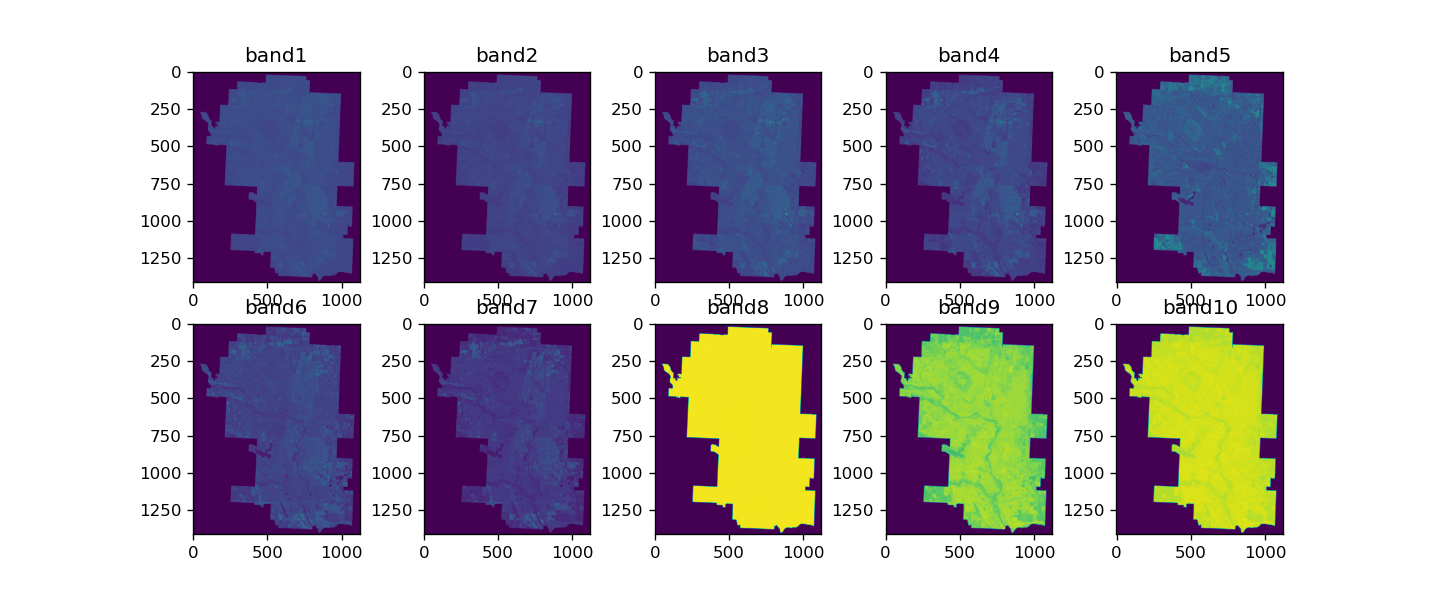

In [146]:
fig, ax = plt.subplots(ncols=5, nrows=2, figsize=(12, 5), dpi=120)
ax = ax.flatten()

for index in range(len(dataset_list)):
    ax[index].imshow(dataset_list[index].read()[0, :, :])
    ax[index].set_title(f"band{index+1}")

Text(0.5, 0.98, 'True Color Composite')

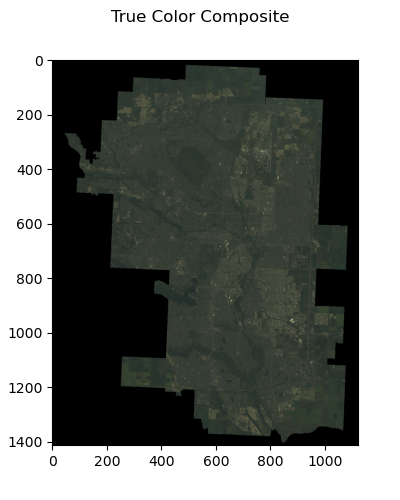

In [147]:
# images = np.concatenate([dataset_list[i].read() for i in [3,2,1]],axis=0)

images = np.concatenate([(dataset_list[i].read() / dataset_list[i].read().max() * 255).astype('int') for i in [3,2,1]],axis=0)
fig, ax = plt.subplots(figsize=(4, 5))
ax.imshow(images.transpose(1,2,0))
fig.suptitle("True Color Composite")

In [148]:
# (dataset_list[3].read() / dataset_list[3].read().max() * 255).max()

### Calculating Normalized Difference Vegetation Index

In [149]:
images_5 = dataset_list[4].read()[0, :, :]
images_4 = dataset_list[3].read()[0, :, :]
ndvi = (images_5 - images_4) / (images_5 + images_4)
ndvi.shape

/tmp/ipykernel_4448/2771274744.py:3: RuntimeWarning: invalid value encountered in true_divide
  ndvi = (images_5 - images_4) / (images_5 + images_4)


(1413, 1121)

In [150]:
np.nanmax(ndvi),np.nanmin(ndvi)

(86.20930232558139, 0.0)

Text(0.5, 0.98, 'TNDVI for Calagary')

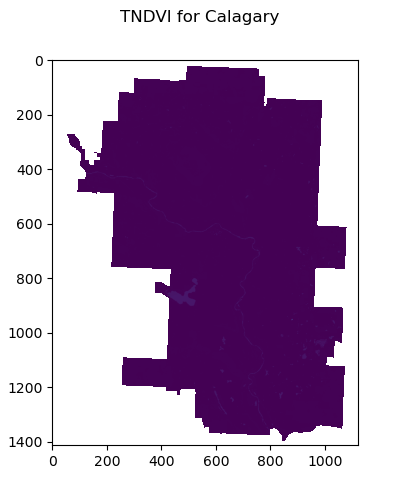

In [151]:
fig, ax = plt.subplots(figsize=(4, 5))
ax.imshow(ndvi)
fig.suptitle("TNDVI for Calagary")

### 矢量数据

In [152]:
calgary_trainingpointer_gpd = gpd.read_file("数据集/data20220907/calgary_trainingPointers")
# calgary_trainingpointer_gpd = calgary_trainingpointer_gpd.to_crs(dataset_list[0].crs.to_string())
calgary_trainingpointer_gpd

,class,id,geometry
0,clouds,1.0,POINT (-114.24357 51.12257)
1,clouds,1.0,POINT (-114.21657 51.12176)
2,clouds,1.0,POINT (-114.21073 51.12747)
3,clouds,1.0,POINT (-114.20116 51.12273)
4,clouds,1.0,POINT (-114.20370 51.12623)
...,...,...,...
696,water,4.0,POINT (-113.98607 50.86494)
697,water,4.0,POINT (-113.97288 50.85150)
698,water,4.0,POINT (-113.97410 50.85180)
699,water,4.0,POINT (-113.97348 50.85231)


In [153]:
cityboundary_gpd = gpd.read_file("数据集/data20220907/CityBoundary.geojson")

# cityboundary_gpd = cityboundary_gpd.to_crs(dataset_list[0].crs.to_string())
cityboundary_gpd

,city,geometry
0,CALGARY,"POLYGON ((-114.01329 51.21243, -114.01328 51.2..."


In [154]:
hydrology_gpd = gpd.read_file("数据集/data20220907/Hydrology.geojson")
hydrology_gpd

,perimeter,lake_source,feature_type,lake_name,modified_dt,geometry
0,246282.03805549,None,water course,BOW RIVER,2016-04-28,"POLYGON ((-113.88592 50.85995, -113.88591 50.8..."
1,560.10253111,None,lake,None,2016-04-28,"POLYGON ((-114.11757 50.91028, -114.11757 50.9..."
2,668.64838361,None,lake,None,2016-04-28,"POLYGON ((-114.11992 50.91971, -114.11992 50.9..."
3,41.55559065,None,water course,None,2016-04-28,"POLYGON ((-114.25190 51.02269, -114.25190 51.0..."
4,13.34736581,None,water course,None,2016-04-28,"POLYGON ((-114.19277 51.00366, -114.19281 51.0..."
...,...,...,...,...,...,...
334,649.54054944,None,lake,None,2016-04-28,"POLYGON ((-114.21012 51.03827, -114.21018 51.0..."
335,303.66086309,None,lake,None,2016-04-28,"POLYGON ((-114.01852 50.89452, -114.01849 50.8..."
336,15.99628769,None,water course,None,2016-04-28,"POLYGON ((-114.03763 50.86162, -114.03763 50.8..."
337,377.19831,None,lake,None,2016-04-28,"POLYGON ((-113.96479 51.15260, -113.96480 51.1..."


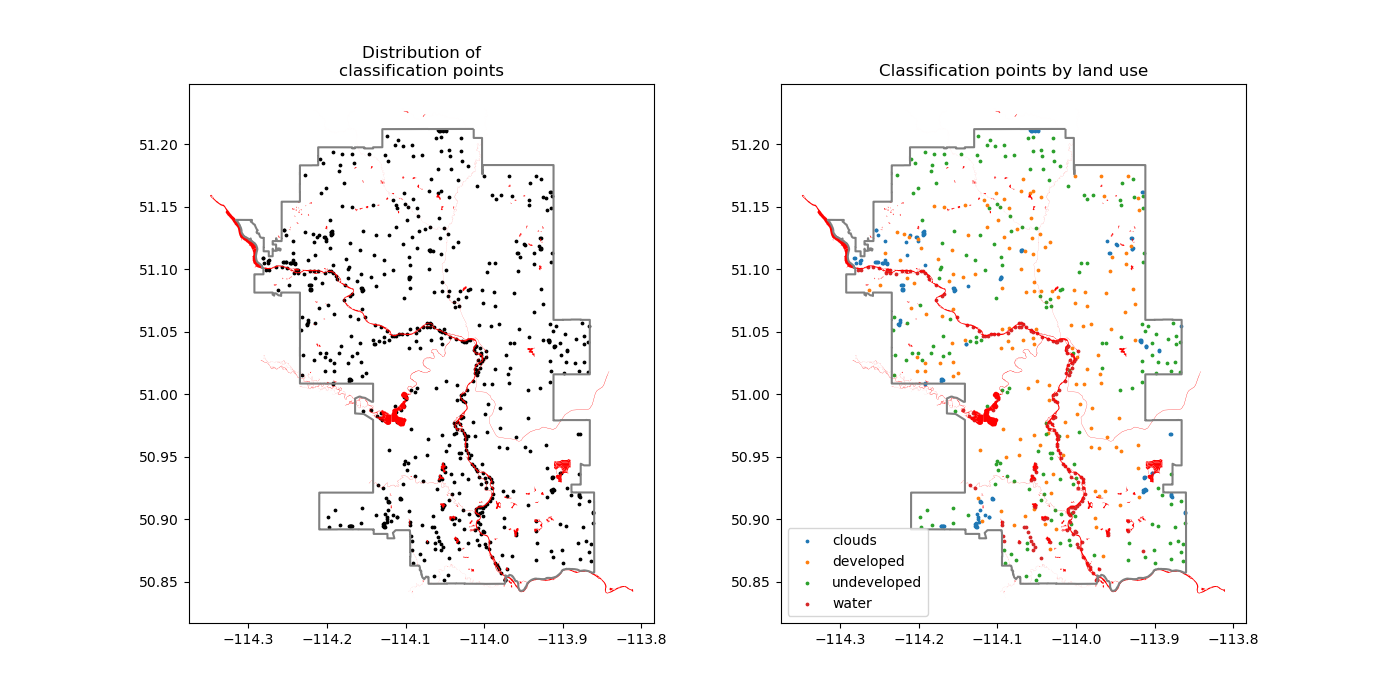

In [155]:
fig, ax = plt.subplots(ncols=2, nrows=1,figsize=(14, 7))
calgary_trainingpointer_gpd.plot(ax=ax[0],color='black',markersize=3)



for temp_type in calgary_trainingpointer_gpd['class'].unique().tolist():
    calgary_trainingpointer_gpd.loc[calgary_trainingpointer_gpd['class'] == temp_type].plot(ax=ax[1], 
    label=temp_type,markersize=3)

for index in range(2):
    cityboundary_gpd.boundary.plot(ax=ax[index], color='gray')
    hydrology_gpd.plot(ax=ax[index], color='red')
ax[0].set_title("Distribution of\nclassification points")
ax[1].set_title("Classification points by land use")
ax[1].legend(loc='lower left')

### Extracting spectral values from the raster

In [159]:
# [dataset_list[i].read().shape for i in range(len(dataset_list))]

all_read_vector = np.concatenate([dataset_list[i].read() for i in range(len(dataset_list))], axis=0)



def location2value(x, y):
    row, col = dataset_list[0].index(x, y)
    res =all_read_vector[:, row, col]
    return pd.Series(res)



trainX = calgary_trainingpointer_gpd.to_crs(dataset_list[0].crs.to_string()).pipe(
    lambda x: x.assign(**{
        'lon':x.geometry.x,
        'lat':x.geometry.y
    })
).pipe(
    lambda x: x.apply(lambda x: location2value(x['lon'], x['lat']), axis=1)
)
trainX

,0,1,2,3,4,5,6,7,8,9
0,23278,24686,26910,29927,34254,30755,19882,5120,29911,27294
1,13592,13627,14518,15678,18062,18903,16396,5138,30276,27412
2,12979,12679,12513,12704,16030,15946,14071,5087,30123,27140
3,13547,13280,13815,14977,16552,15771,13154,5095,31188,28323
4,15238,15537,16206,17117,18014,26436,27730,5139,29918,25979
...,...,...,...,...,...,...,...,...,...,...
696,10015,9163,8331,7501,7036,5991,5768,5036,25666,23959
697,10109,9368,8931,8788,13583,14772,11269,5077,29650,27033
698,9627,8737,7928,7111,6517,5654,5482,5060,28599,26085
699,9679,8743,7797,6960,6569,5704,5522,5055,28434,25817


In [160]:
trainY = calgary_trainingpointer_gpd['class']
trainY

0      clouds
1      clouds
2      clouds
3      clouds
4      clouds
        ...  
696     water
697     water
698     water
699     water
700     water
Name: class, Length: 701, dtype: object

### train a model 

In [161]:
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix

In [163]:

X_train, X_test, y_train, y_test = train_test_split(trainX, trainY, train_size=0.8, random_state=42)
X_train.shape

(560, 10)

In [164]:
y_test.shape

(141,)

In [167]:
rf_fit = RandomForestClassifier()#SVC()
rf_fit.fit(X_train, y_train)

RandomForestClassifier()

In [171]:
# 混淆矩阵 on 训练集
predict_train = rf_fit.predict(X_train)

confusion_matrix(y_true=y_train, y_pred=predict_train)

array([[110,   0,   0,   0],
       [  0, 126,   0,   0],
       [  0,   0, 159,   0],
       [  0,   0,   0, 165]])

In [172]:
# 混淆矩阵 on 测试集
predict_test = rf_fit.predict(X_test)
confusion_matrix(y_test, predict_test)

array([[35,  2,  0,  0],
       [ 2, 26,  0,  0],
       [ 1,  1, 39,  0],
       [ 0,  2,  0, 33]])

In [215]:
np.sum(y_test == predict_test) / predict_test.shape[0] * 100

94.32624113475178

In [179]:
predict_all_x = np.hstack([dataset_list[i].read().reshape(-1, 1) for i in range(len(dataset_list))])
print(predict_all_x.shape)


(1583973, 10)


In [180]:
predict_all_result = rf_fit.predict(predict_all_x)


In [284]:
class_list = np.unique(predict_all_result).tolist()
class_dict = {value:index for index, value in enumerate(class_list)}
print(class_dict)

{'clouds': 0, 'developed': 1, 'undeveloped': 2, 'water': 3}


In [285]:
result = pd.DataFrame({'class':predict_all_result})['class'].map(class_dict).values.reshape(dataset_list[0].read().shape[1:])
result

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

In [286]:
# dataset_list[0].bounds


In [287]:
# mask 
# 因为有的数据点，不是区域内的，虽然做了预测，但是结果并不对，要mask掉
import shapely.vectorized
from shapely.geometry import shape


cityboundary_gpdnewcrs = cityboundary_gpd.to_crs(dataset_list[0].crs.to_string())

x = np.linspace(dataset_list[0].bounds.left, dataset_list[0].bounds.right, dataset_list[0].read().shape[2])
y = np.linspace(dataset_list[0].bounds.bottom, dataset_list[0].bounds.top, dataset_list[0].read().shape[1])[::-1]
xx, yy = np.meshgrid(x, y)

mask_ = shapely.vectorized.contains(shape(cityboundary_gpdnewcrs['geometry'][0]), xx, yy)
mask_.shape

(1413, 1121)

In [288]:
result_mask = result.copy().astype(np.float)
result_mask[~mask_] = np.nan

/tmp/ipykernel_4448/1680051378.py:1: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  result_mask = result.copy().astype(np.float)


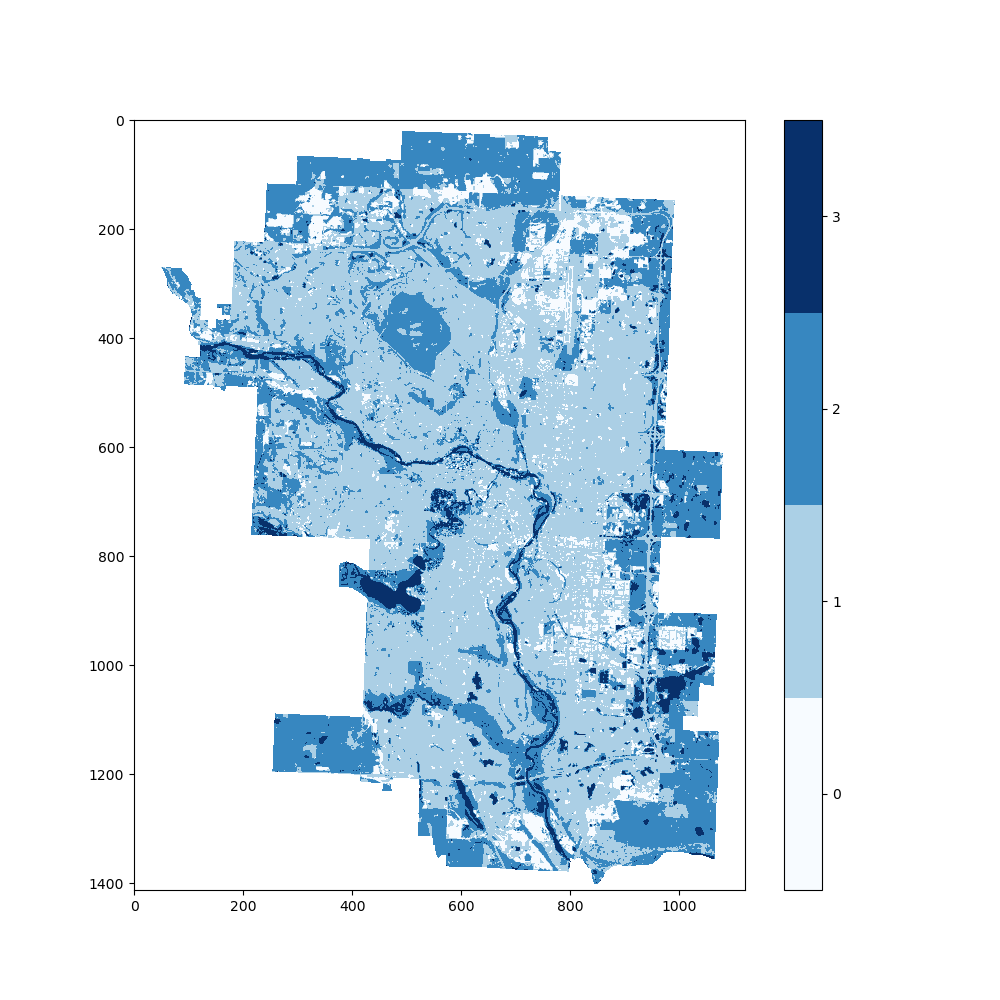

In [290]:
fig, ax = plt.subplots(figsize=(10, 10))
cmap = cm.get_cmap('Blues', len(class_list))
clb = ax.imshow(result_mask,cmap=cmap, vmax=3+0.5, vmin=0-0.5)
fig.colorbar(clb,ticks=range(4))

# ax[1].imshow(mask_)

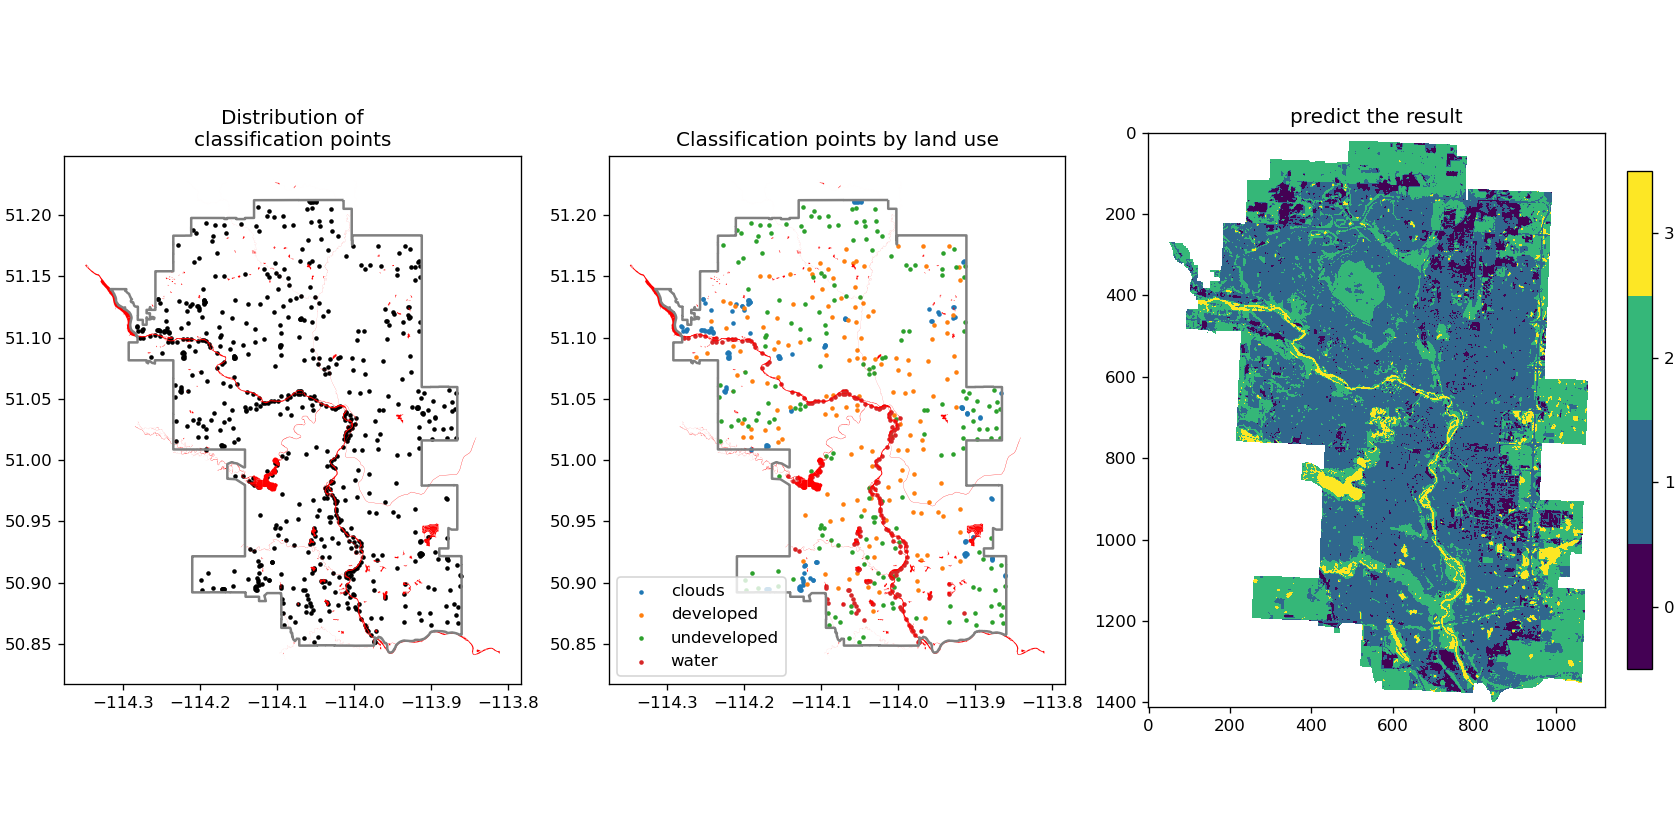

In [293]:
fig, ax = plt.subplots(ncols=3, nrows=1,figsize=(14, 7), dpi=120,constrained_layout=True)
calgary_trainingpointer_gpd.plot(ax=ax[0],color='black',markersize=3)



for temp_type in calgary_trainingpointer_gpd['class'].unique().tolist():
    calgary_trainingpointer_gpd.loc[calgary_trainingpointer_gpd['class'] == temp_type].plot(ax=ax[1], 
    label=temp_type,markersize=3)

for index in range(2):
    cityboundary_gpd.boundary.plot(ax=ax[index], color='gray')
    hydrology_gpd.plot(ax=ax[index], color='red')
ax[0].set_title("Distribution of\nclassification points")
ax[1].set_title("Classification points by land use")
ax[1].legend(loc='lower left')

cmap = cm.get_cmap('viridis', len(class_list))
clb = ax[2].imshow(result_mask,cmap=cmap, vmax=3+0.5, vmin=0-0.5)
ax[2].set_title("predict the result")
fig.colorbar(clb,ticks=range(4), shrink=0.6)
fig.savefig("结果/plot20220907.png")

In [294]:
class_dict

{'clouds': 0, 'developed': 1, 'undeveloped': 2, 'water': 3}